---
# Notebook para avaliar performance do modelo em produção

Neste notebook vamos explorar a parformance de captura de fraudes do modelo atualmente em produção.

---

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from scipy.stats import ks_2samp
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

# Configs Pandas
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200

# Configs matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.facecolor'] = '#f0f0f0'

main_colors = ["#fee605", "#454463"]

warnings.filterwarnings("ignore")

In [2]:
project_root = Path().resolve().parents[0]

In [3]:
df = pd.read_csv(os.path.join(project_root, "data", "raw", "dados.csv"), delimiter=",", decimal=".")

# Manipulando datas

In [4]:
df['fecha'] = pd.to_datetime(df['fecha'])

In [5]:
df['date'] = df['fecha'].dt.date
df['time'] = df['fecha'].dt.time

In [6]:
def get_week_from_date(date: datetime.date) -> int:
    """
    Retorna o número da semana do ano para uma data específica.
    
    Args:
        date (datetime.date): Data para extrair a semana.
    
    Returns:
        int: Número da semana do ano (1-53).
    """
    return date.isocalendar()[1]

df['semana'] = df['date'].apply(lambda row: get_week_from_date(row))

In [7]:
df['date'] = pd.to_datetime(df['date'])

# Avaliando modelo atual

In [8]:
# filtrando colunas de interesse
df = df[["date", "semana", "score", "monto", "fraude"]]

## Distribuição do score 

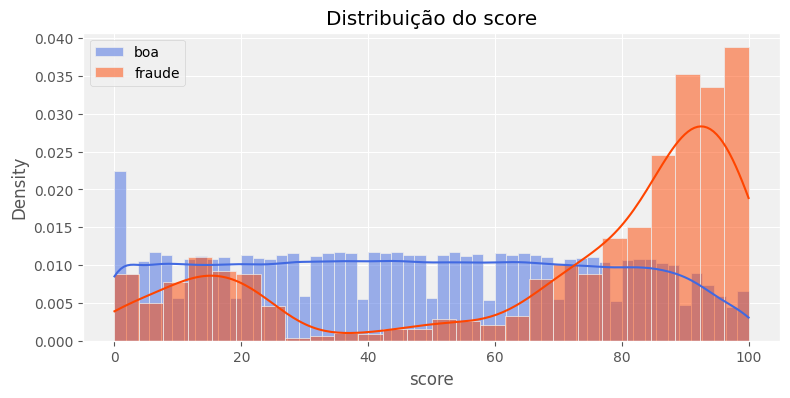

In [9]:
plt.figure()
sns.histplot(df[df['fraude']==0], x="score", kde=True, stat='density', label='boa', color="royalblue")
sns.histplot(df[df['fraude']==1], x="score", kde=True, stat='density', label='fraude', color="orangered")
plt.legend()
plt.title("Distribuição do score")
plt.show()

É possível ver que o modelo discrimina a fraude, tendo maior concentração das fraudes nos scores altos enquanto a curva de densidade das boas descresce nos scores mais altos.

In [10]:
df['faixa_score'] = pd.cut(df['score'], bins=10)

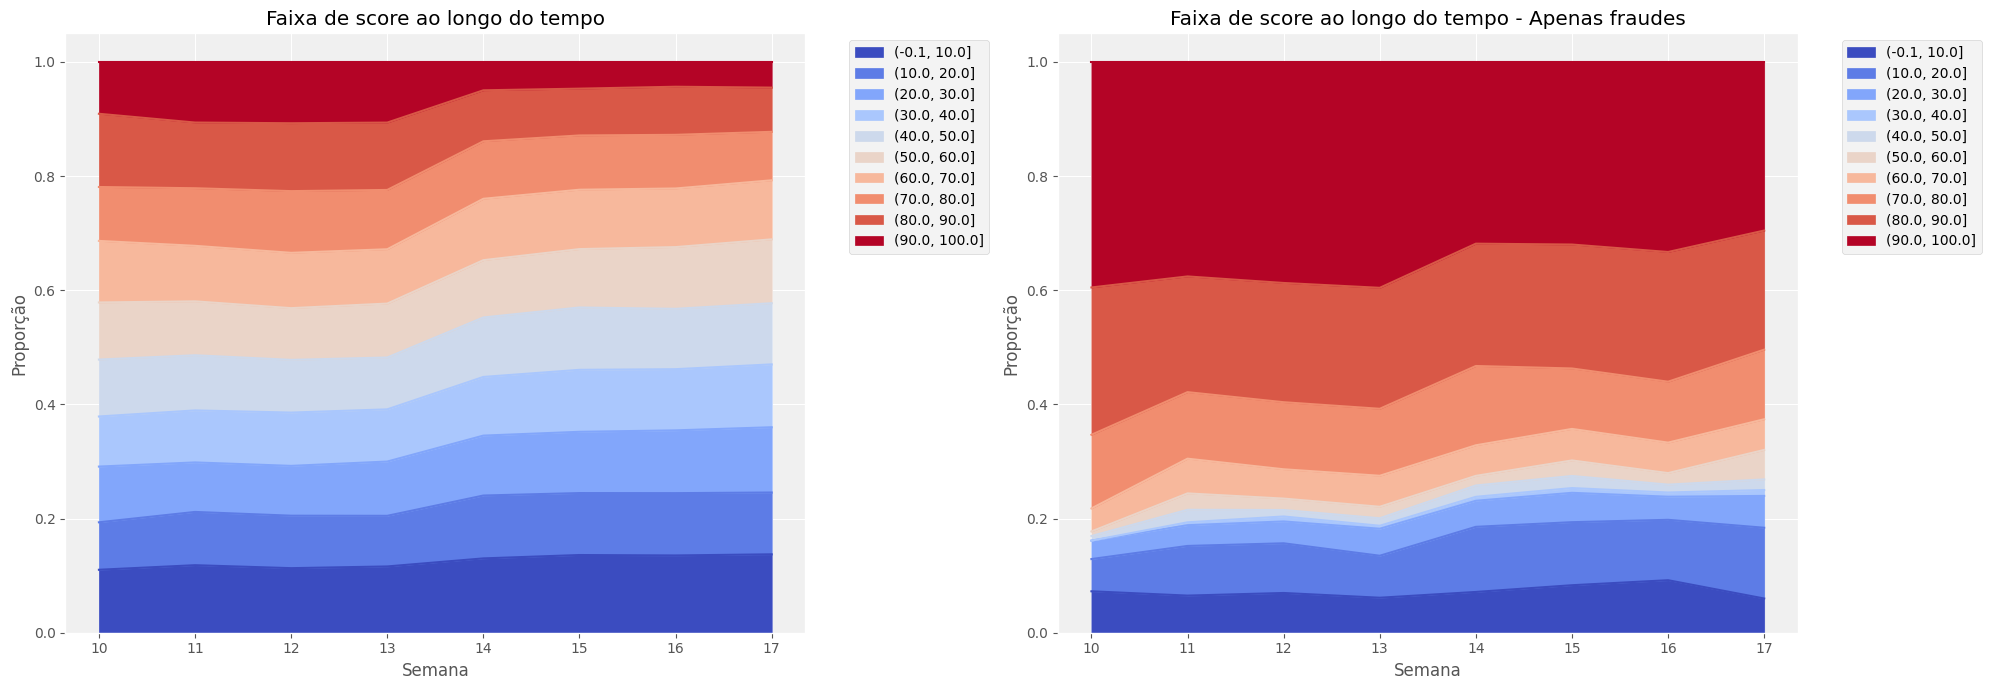

In [11]:
f, ax = plt.subplots(1, 2, figsize=(20, 7))

pivot_table = df.groupby(["semana", "faixa_score"]).size().unstack(fill_value=0)
pivot_table_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0)
pivot_table_pct.plot(kind='area', stacked=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title("Faixa de score ao longo do tempo")
ax[0].set_xlabel("Semana")
ax[0].set_ylabel("Proporção")

ax[0].legend(
    bbox_to_anchor=(1.05, 1),  
    loc='upper left'
)

pivot_table = df[df['fraude'] == 1].groupby(["semana", "faixa_score"]).size().unstack(fill_value=0)
pivot_table_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0)
pivot_table_pct.plot(kind='area', stacked=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title("Faixa de score ao longo do tempo - Apenas fraudes")
ax[1].set_xlabel("Semana")
ax[1].set_ylabel("Proporção")

ax[1].legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

Isso indica degradação do modelo, uma vez que a proporção de scores mais altos vem caindo ao longo do tempo.

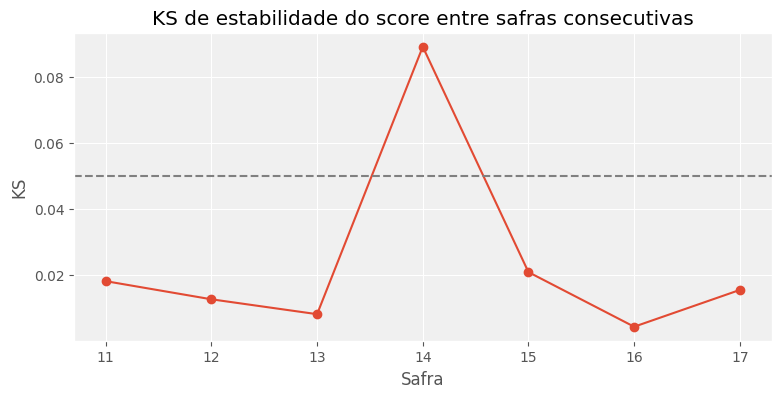

In [12]:
def plot_ks_stability_between_safras(df, score_col='score', safra_col='safra'):
    """
    Compara a distribuição de `score` entre cada par de safras consecutivas
    usando a estatística KS, e plota um gráfico de linhas mostrando o valor
    do KS para cada par de safras.

    Args:
        df (pd.DataFrame): DataFrame contendo as colunas de safra e score.
        score_col (str): Nome da coluna que contém o score numérico.
        safra_col (str): Nome da coluna que identifica a safra.
    """
    safra_unicas = sorted(df[safra_col].unique())
    ks_results = []

    for i in range(len(safra_unicas) - 1):
        safra_atual = safra_unicas[i]
        safra_seguinte = safra_unicas[i + 1]

        scores_safra_atual = df[df[safra_col] == safra_atual][score_col]
        scores_safra_seguinte = df[df[safra_col] == safra_seguinte][score_col]

        ks_stat, _ = ks_2samp(scores_safra_atual, scores_safra_seguinte)

        ks_results.append({
            'safra_atual': safra_atual,
            'safra_seguinte': safra_seguinte,
            'KS': ks_stat
        })

    ks_df = pd.DataFrame(ks_results)

    plt.figure()
    plt.plot(ks_df['safra_seguinte'], ks_df['KS'], marker='o')
    plt.title('KS de estabilidade do score entre safras consecutivas')
    plt.xlabel('Safra')
    plt.ylabel('KS')
    plt.axhline(0.05, color='gray', linestyle='--')
    plt.show()

plot_ks_stability_between_safras(df, safra_col="semana")


Na semana 14 do ano, o KS foi maior que o limite aceitável de 0.05.

## Performance

### Confusion Matrix

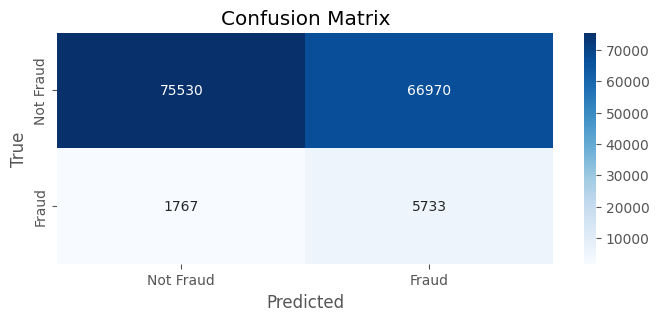

Classification Report:

              precision    recall  f1-score   support

   Not Fraud       0.98      0.53      0.69    142500
       Fraud       0.08      0.76      0.14      7500

    accuracy                           0.54    150000
   macro avg       0.53      0.65      0.42    150000
weighted avg       0.93      0.54      0.66    150000



In [13]:
def plot_confusion_matrix_and_classification_report(y_true, y_pred, labels=None):
    """Plota a matriz de confusão e o classification report.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(8, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=labels)
    print("Classification Report:\n")
    print(report)

y_true = df['fraude']
y_pred = (df['score'] >= 50).astype(int)
plot_confusion_matrix_and_classification_report(y_true, y_pred, labels=['Not Fraud', 'Fraud'])

### Métricas Parciais

Em fraudes temos em geral dois principais KPIs: Recall e Impacto. O grande desafio desta área é aumentar o recall e reduzir o impacto, mas isso é difícil uma vez que são um trade-off. Então na maioria das vezes quando aumentamos o recall, também aumentamos o impacto e vice-versa.

Sabendo disso, devemos manter nosso impacto controlado, uma vez que em geral bloquamos transações e quando fazemos isso de forma errada, criamos um atrito com o cliente. Portanto para analisar de forma mais acertiva a performance de nossos modelo, avaliamos o recall para um determinado impacto definido, geralmente definido pela estratégia.

Exemplo:
- __ROC_AUC@0.05__: calculamos a área curva ROC, para um máx. FPR (impacto) de 5%.

In [14]:
def generate_model_metrics(y_test, y_pred_proba, max_fpr=0.05):
    """Model performance metrics"""
    
    # Calculate ROC AUC score with a partial area under the curve
    roc_auc_partial = float(roc_auc_score(y_test, y_pred_proba, max_fpr=max_fpr))
    
    # Calculate recall and precision with a threshold based on max_fpr
    threshold = np.percentile(y_pred_proba, 100 * (1 - max_fpr))
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    recall_partial = recall_score(y_test, y_pred)
    precision_partial = precision_score(y_test, y_pred)
    
    metrics = {        
        f'ROC_AUC@{max_fpr}': roc_auc_partial,
        f'Recall@{max_fpr}': recall_partial,
        f'Precision@{max_fpr}': precision_partial
    }
    
    return metrics

generate_model_metrics(df['fraude'], df['score'], max_fpr=0.05)

{'ROC_AUC@0.05': 0.5743256627092861,
 'Recall@0.05': 0.278,
 'Precision@0.05': 0.24851013110846246}

### Tabela de resultados

In [15]:
def gerar_metricas_por_score(df, 
                             score_col='score',
                             target_col='fraude',
                             valor_col='monto'):
    """
    Gera uma tabela de métricas por threshold de score.
    
    Args:
        df (pd.DataFrame): DataFrame contendo as colunas de score, fraude (0/1) e monto.
        score_col (str): Nome da coluna que contém o score.
        target_col (str): Nome da coluna que contém a variável fraude (0 ou 1).
        valor_col (str): Nome da coluna que contém o valor monetário (monto).

    Returns:
        pd.DataFrame: DataFrame com, para cada threshold, as métricas:
        [threshold, boas_#, fraudes_#, fraudes_$, recall, precision, recall_$, precision_$]
    """

    total_fraudes = df[target_col].sum()
    total_fraudes_valor = df.loc[df[target_col] == 1, valor_col].sum()

    thresholds = np.sort(df[score_col].unique())[::-1]

    resultados = []
    for thr in thresholds:
        df_acima_thr = df[df[score_col] >= thr]

        boas_num = df_acima_thr[df_acima_thr[target_col] == 0].shape[0]
        fraudes_num = df_acima_thr[df_acima_thr[target_col] == 1].shape[0]
        impacto = boas_num / df.shape[0]
        fraudes_val = df_acima_thr.loc[df_acima_thr[target_col] == 1, valor_col].sum()

        recall = fraudes_num / total_fraudes if total_fraudes > 0 else 0
        precision = fraudes_num / (fraudes_num + boas_num) if (fraudes_num + boas_num) > 0 else 0

        recall_val = fraudes_val / total_fraudes_valor if total_fraudes_valor > 0 else 0
        valor_acima_thr = df_acima_thr[valor_col].sum()
        precision_val = fraudes_val / valor_acima_thr if valor_acima_thr > 0 else 0

        resultados.append({
            'threshold': thr,
            'boas_#': boas_num,
            'fraudes_#': fraudes_num,
            'fraudes_$': fraudes_val,
            'impacto': impacto,
            'recall': recall,
            'precision': precision,
            'recall_$': recall_val,
            'precision_$': precision_val
        })

    df_resultados = pd.DataFrame(resultados)
    return df_resultados


In [16]:
df_resultados = gerar_metricas_por_score(df, score_col="score")
df_resultados

,threshold,boas_#,fraudes_#,fraudes_$,impacto,recall,precision,recall_$,precision_$
0,100,1242,576,37675.69,0.008280,0.076800,0.316832,0.068843,0.350618
1,99,1714,743,50684.80,0.011427,0.099067,0.302401,0.092614,0.341723
2,98,2239,924,65861.12,0.014927,0.123200,0.292128,0.120345,0.331719
3,97,2874,1119,78016.63,0.019160,0.149200,0.280240,0.142556,0.319958
4,96,3607,1342,93133.10,0.024047,0.178933,0.271166,0.170177,0.306753
...,...,...,...,...,...,...,...,...,...
96,4,134388,7244,533751.83,0.895920,0.965867,0.051147,0.975297,0.085913
97,3,135607,7284,536615.46,0.904047,0.971200,0.050976,0.980529,0.085682
98,2,136675,7321,538927.67,0.911167,0.976133,0.050842,0.984754,0.085481
99,1,137682,7349,540660.87,0.917880,0.979867,0.050672,0.987921,0.085179


In [17]:
df_resultados_faixa = gerar_metricas_por_score(df, score_col="faixa_score")
df_resultados_faixa

,threshold,boas_#,fraudes_#,fraudes_$,impacto,recall,precision,recall_$,precision_$
0,"(90.0, 100.0]",8641,2640,186078.79,0.057607,0.352000,0.234022,0.340012,0.267427
1,"(80.0, 90.0]",22069,4245,339448.71,0.147127,0.566000,0.161321,0.620257,0.207950
2,"(70.0, 80.0]",36066,5123,405212.55,0.240440,0.683067,0.124378,0.740424,0.169481
3,"(60.0, 70.0]",50769,5532,436316.89,0.338460,0.737600,0.098258,0.797259,0.145150
4,"(50.0, 60.0]",65495,5713,444622.20,0.436633,0.761733,0.080230,0.812435,0.124956
5,"(40.0, 50.0]",80423,5840,450798.43,0.536153,0.778667,0.067700,0.823720,0.109486
6,"(30.0, 40.0]",95321,5893,452929.00,0.635473,0.785733,0.058223,0.827614,0.096862
7,"(20.0, 30.0]",109903,6223,477716.87,0.732687,0.829733,0.053588,0.872907,0.091220
8,"(10.0, 20.0]",124231,6953,514177.76,0.828207,0.927067,0.053002,0.939530,0.088579
9,"(-0.1, 10.0]",142500,7500,547271.12,0.950000,1.000000,0.050000,1.000000,0.083828


### Curva Recall x Impacto

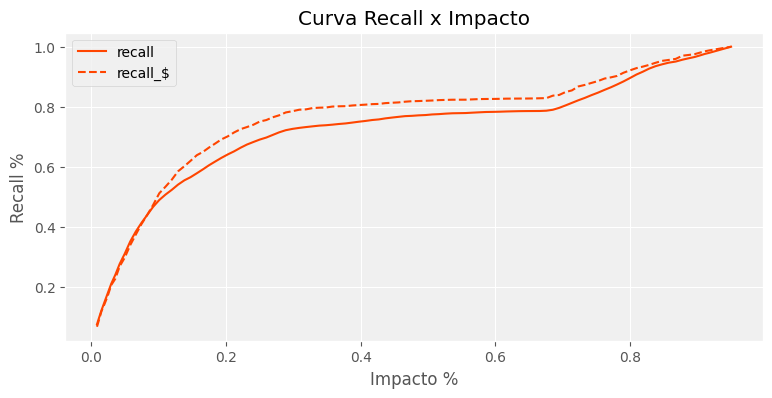

In [18]:
plt.figure()
plt.plot(df_resultados["impacto"], df_resultados["recall"], label="recall", color="orangered")
plt.plot(df_resultados["impacto"], df_resultados["recall_$"], label="recall_$", ls="--", color="orangered")
plt.title("Curva Recall x Impacto")
plt.xlabel("Impacto %")
plt.ylabel("Recall %")
plt.legend()
plt.show()

### Curva ROC & Precison-Recall

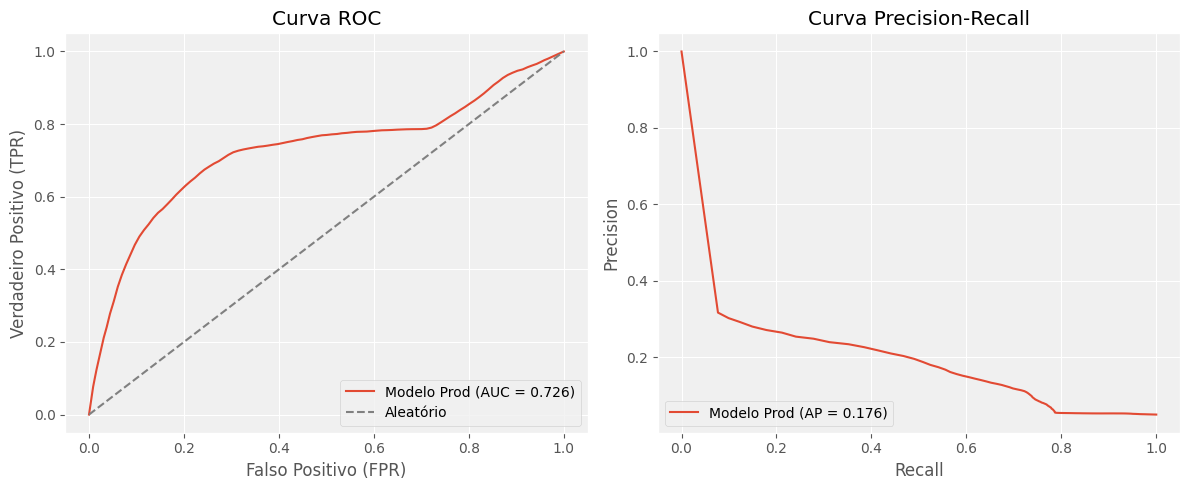

In [19]:
def plotar_roc_e_precision_recall(y_true, y_score, label_modelo="Modelo"):
    """
    Gera dois gráficos lado a lado: a curva ROC e a curva Precision-Recall.
    
    Parâmetros:
    -----------
    y_true : array-like
        Vetor com os valores reais (0 para não-fraude e 1 para fraude).
    y_score : array-like
        Vetor com os scores (probabilidades ou pontuações do modelo).
    label_modelo : str
        Nome do modelo a ser exibido na legenda dos gráficos.
    """
    # Curva ROC
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
    auc_value = roc_auc_score(y_true, y_score)
    
    # Curva Precision-Recall
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    
    # Cria os subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico da curva ROC
    axes[0].plot(fpr, tpr, label=f"{label_modelo} (AUC = {auc_value:.3f})")
    axes[0].plot([0, 1], [0, 1], linestyle='--', label="Aleatório", color='gray')
    axes[0].set_xlabel("Falso Positivo (FPR)")
    axes[0].set_ylabel("Verdadeiro Positivo (TPR)")
    axes[0].set_title("Curva ROC")
    axes[0].legend(loc="lower right")
    
    # Gráfico da curva Precision-Recall
    axes[1].plot(recall, precision, label=f"{label_modelo} (AP = {avg_precision:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Curva Precision-Recall")
    axes[1].legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
    
plotar_roc_e_precision_recall(df["fraude"], df["score"], label_modelo="Modelo Prod")

### Avaliando ao longo do tempo

In [20]:
def metrics_time_series(df):
    # Inicializa as listas para armazenar as métricas por semana
    semanas = sorted(df['semana'].unique())
    roc_auc_semanas = []
    ks_semanas = []
    recall_semanas = []
    precision_semanas = []
    
    for semana in semanas:
        df_semana = df[df['semana'] == semana]
        
        # Cálculo do ROC AUC
        roc_auc = roc_auc_score(df_semana["fraude"], df_semana["score"])
        roc_auc_semanas.append(roc_auc)
        
        # Cálculo do KS usando roc_curve
        fpr, tpr, _ = roc_curve(df_semana["fraude"], df_semana["score"])
        ks = np.max(np.abs(tpr - fpr))
        ks_semanas.append(ks)
        
        # Definindo a predição com threshold 0.5
        preds = (df_semana["score"] >= 0.5).astype(int)
        
        # Cálculo do Recall e Precision
        rec = recall_score(df_semana["fraude"], preds)
        prec = precision_score(df_semana["fraude"], preds)
        recall_semanas.append(rec)
        precision_semanas.append(prec)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    
    # Gráfico 1: ROC AUC por semana
    axes[0, 0].plot(semanas, roc_auc_semanas, marker='o')
    axes[0, 0].set_title('ROC AUC por Semana')
    axes[0, 0].set_xlabel('Semana')
    axes[0, 0].set_ylabel('ROC AUC')
    
    # Gráfico 2: KS por semana
    axes[0, 1].plot(semanas, ks_semanas, marker='o')
    axes[0, 1].set_title('KS por Semana')
    axes[0, 1].set_xlabel('Semana')
    axes[0, 1].set_ylabel('KS')
    
    # Gráfico 3: Recall por semana
    axes[1, 0].plot(semanas, recall_semanas, marker='o')
    axes[1, 0].set_title('Recall por Semana')
    axes[1, 0].set_xlabel('Semana')
    axes[1, 0].set_ylabel('Recall')
    
    # Gráfico 4: Precision por semana
    axes[1, 1].plot(semanas, precision_semanas, marker='o')
    axes[1, 1].set_title('Precision por Semana')
    axes[1, 1].set_xlabel('Semana')
    axes[1, 1].set_ylabel('Precision')
    
    plt.tight_layout()
    plt.show()

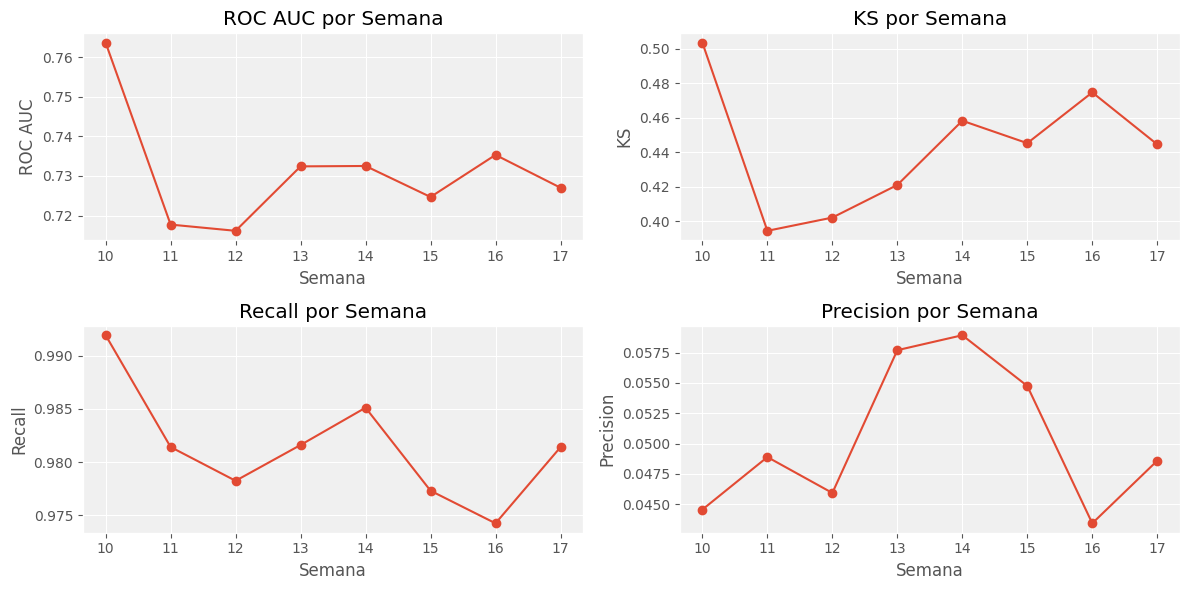

In [21]:
metrics_time_series(df)

---
# Respondendo as perguntas


## 5. Com a informação adicional de que uma fraude custa 10 vezes mais para a empresa do que o bloqueio incorreto de um pagamento, o que você faria de diferente?


Sabendo que o custo de um fraude é 10 vezes maior que um bloqueio incorreto, utilizaria essa informação para ajustar o modelo e ter um melhor retorno. Por exemplo, poderia passar o peso das instâncias no treinamento (`sample_weight`), assim o modelo teria a penalidade ajustada para o que foi enunciado. Ou ainda podemos plotar a curva de score x custo, levando em consideração a proporção mencionada e assim escolher o corte que tenha menor custo.


In [22]:
df.loc[df['fraude'] == 1, 'custo'] = df['monto'] * 10
df.loc[df['fraude'] == 0, 'custo'] = df['monto']

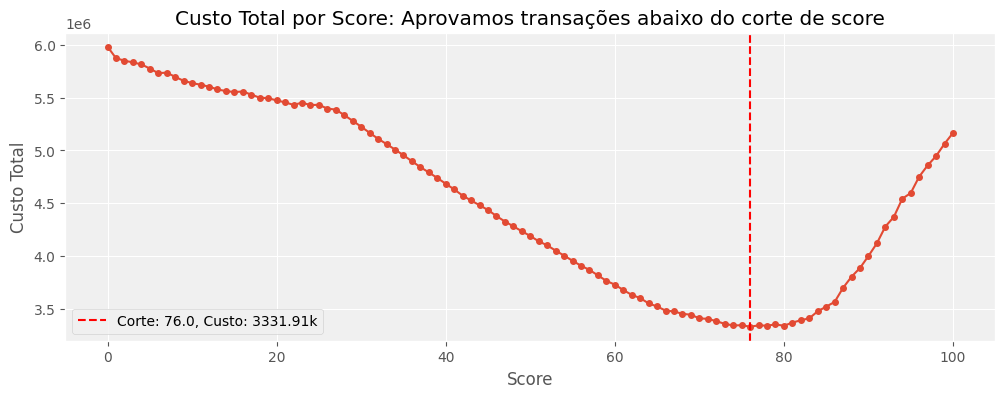

In [23]:
def calcular_custo(df, score_col='score', target_col='fraude', valor_col='custo'):
    """Calcula o custo total para cada possível corte de score
    """
    thresholds = np.sort(df[score_col].unique())
    custos = []

    for thr in thresholds:
        df_acima_thr = df[df[score_col] >= thr]
        df_abaixo_thr = df[df[score_col] < thr]

        custo_fraudes_nao_detectadas = df_abaixo_thr[df_abaixo_thr[target_col] == 1][valor_col].sum()
        custo_bloqueios_incorretos = df_acima_thr[df_acima_thr[target_col] == 0][valor_col].sum()

        custo_total = custo_fraudes_nao_detectadas + custo_bloqueios_incorretos
        custos.append({'threshold': thr, 'custo_total': custo_total})

    df_custos = pd.DataFrame(custos)

    plt.figure(figsize=(12, 4))
    plt.plot(df_custos['threshold'], df_custos['custo_total'], marker='o', markersize=4)
    min_custo = df_custos.loc[df_custos['custo_total'].idxmin()]
    plt.axvline(min_custo['threshold'], color='red', linestyle='--', label=f"Corte: {min_custo['threshold']}, Custo: {min_custo['custo_total']/1000:.2f}k")
    plt.title('Custo Total por Score: Aprovamos transações abaixo do corte de score')
    plt.xlabel('Score')
    plt.ylabel('Custo Total')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/custo_total_score.png')
    plt.show()

    return df_custos

df_custos = calcular_custo(df)

## 6. Queremos encontrar o ponto de corte ideal para o modelo já treinado apresentado na parte (Score, onde 0 (zero) é o risco mais baixo e 100 (cem) o mais alto). Sabemos que MELI ganha 10% do valor de um pagamento aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do pagamento. Defina o ponto de corte que maximize os lucros do MELI, de forma que todos os pagamentos com menor Score sejam aprovados e os maiores sejam rejeitados.

In [24]:
df.loc[df['fraude'] == 1, 'retorno'] = df['monto'] 
df.loc[df['fraude'] == 0, 'retorno'] = df['monto'] * 0.1

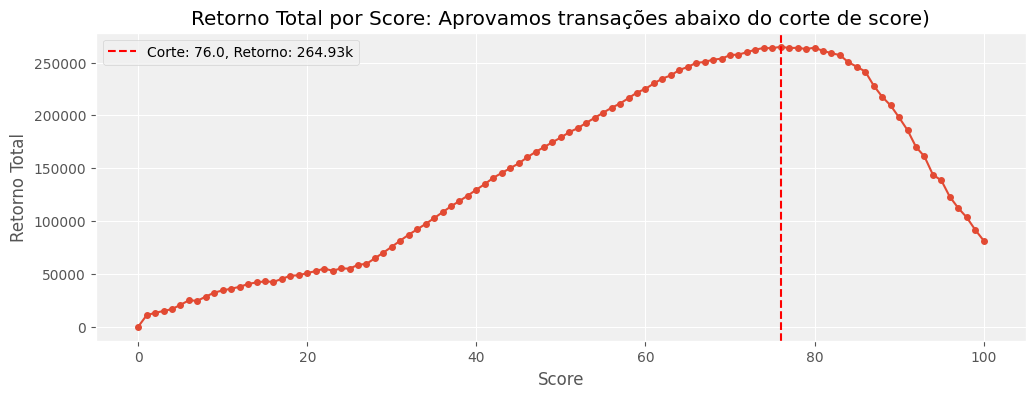

In [25]:
def calcular_retorno(df, score_col='score', target_col='fraude', valor_col='retorno'):
    """Calcula o retorno total para cada possível corte de score
    """
    thresholds = np.sort(df[score_col].unique())
    retornos = []

    for thr in thresholds:
        df_abaixo_thr = df[df[score_col] < thr]

        custo_fraudes_nao_detectadas = df_abaixo_thr[df_abaixo_thr[target_col] == 1][valor_col].sum()
        retorno_aprovadas_corretamente = df_abaixo_thr[df_abaixo_thr[target_col] == 0][valor_col].sum()

        retorno_total = retorno_aprovadas_corretamente - custo_fraudes_nao_detectadas
        retornos.append({'threshold': thr, 'retorno_total': retorno_total})

    df_retornos = pd.DataFrame(retornos)

    plt.figure(figsize=(12, 4))
    plt.plot(df_retornos['threshold'], df_retornos['retorno_total'], marker='o', markersize=4)
    max_retorno = df_retornos.loc[df_retornos['retorno_total'].idxmax()]
    plt.axvline(max_retorno['threshold'], color='red', linestyle='--', label=f"Corte: {max_retorno['threshold']}, Retorno: {max_retorno['retorno_total']/1000:.2f}k")
    plt.title('Retorno Total por Score: Aprovamos transações abaixo do corte de score)')
    plt.xlabel('Score')
    plt.ylabel('Retorno Total')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/retorno_total_score.png')
    plt.show()

    return df_retornos

df_retornos = calcular_retorno(df)
